# A finite element analysis of elastic contact problem

In this example of a deformable ``cylinder 1`` enters in contact with a deformable  ``cylinder 2``. We use here python interface, translate this program for another interface or in C++ is easy (see the previous example).

![Kontakt_paralleler_Zylinder](https://upload.wikimedia.org/wikipedia/commons/e/ef/Kontakt_paralleler_Zylinder.jpg)

## The problem setting

Let $\Omega^{1} \subset \mathbb{R}^{2}$ be the reference of a 2D cylinder 1 and $\Omega^{2} \subset \mathbb{R}^{2}$ the reference configuration of a deformable cylinder. We consider small deformation of these two bodies (linearized elasticity) and the contact between them.

## Building the program

Let us begin by loading Getfem and fixing the parameters of the problem

In [1]:
import getfem as gf
import numpy as np
import pyvista as pv
from pyvirtualdisplay import Display


display = Display(visible=0, size=(1024, 1024))

E1 = E2 = 200000.0 # Yong Modulus (MPa)
nu1 = nu2 = 0.3 # Poisson ratio
clambda1 = E1*nu1/((1+nu1)*(1-2*nu1)) # First Lame coefficient (MPa)
clambda2 = E2*nu2/((1+nu2)*(1-2*nu2)) # First Lame coefficient (MPa)
cmu1 = E1/(2*(1+nu1)) # Second Lame coefficient (MPa)
cmu2 = E2/(2*(1+nu2)) # Second Lame coefficient (MPa)
clambdastar1 = 2*clambda1*cmu1/(clambda1+2*cmu1) # Lame coefficient for Plane stress (MPa)
clambdastar2 = 2*clambda2*cmu2/(clambda2+2*cmu2) # Lame coefficient for Plane stress (MPa)
F = 200.0 # Force (N)

We consider that the radius of the two cylinder is 5mm.
We load the mesh of the cylinder using the load of a mesh from a GetFEM ascii mesh file (see the documentation of the Mesh object in the python interface).

In [2]:
# !gmsh hertz.mesh -f msh2 -save -o hertz.msh
mesh = gf.Mesh("import", "gmsh", "hertz.msh")
mesh.translate([0.0, 5.0])
P = mesh.pts()

# cvid1
c1 = (P[1, :] >= 0.0)
pid1 = np.compress(c1, list(range(0, mesh.nbpts())))
cvid1 = mesh.cvid_from_pid(pid1)

# cvid2
c2 = (P[1, :] <= 0.0)
pid2 = np.compress(c2, list(range(0, mesh.nbpts())))
cvid2 = mesh.cvid_from_pid(pid2)

mesh1 = gf.Mesh("clone", mesh)
mesh1.del_convex(cvid2)
mesh1.export_to_vtk("mesh1.vtk")

mesh2 = gf.Mesh("clone", mesh)
mesh2.del_convex(cvid1)
mesh2.export_to_vtk("mesh2.vtk")

The result is the following

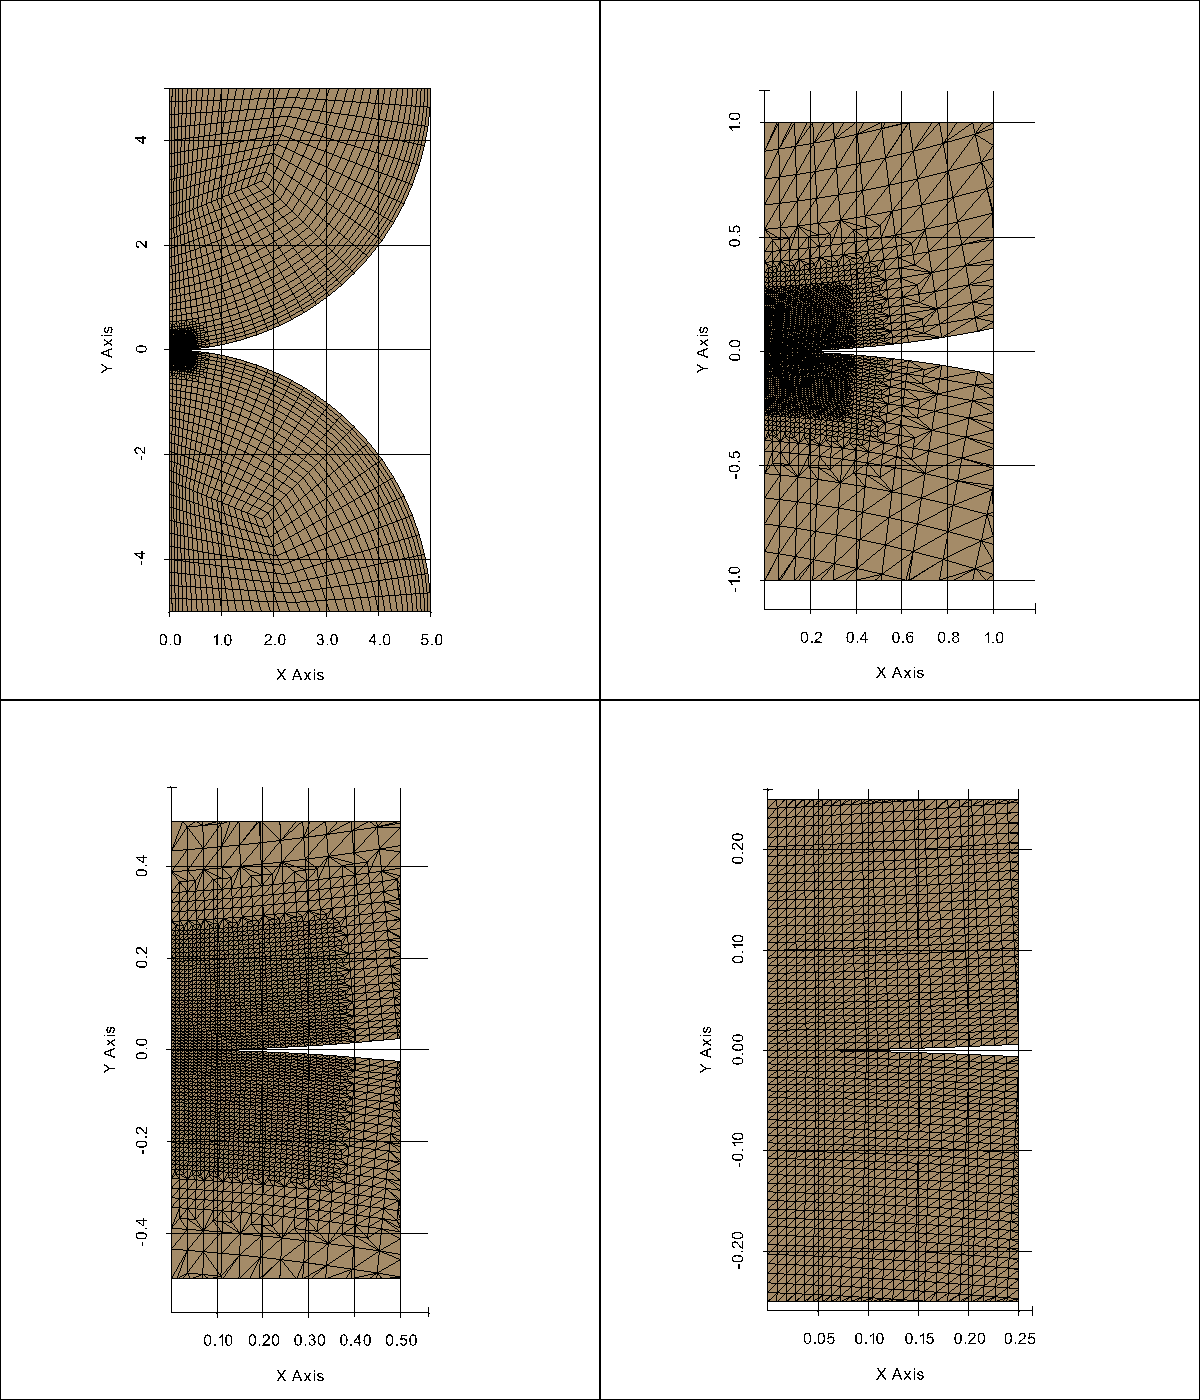

In [3]:
display.start()

m1 = pv.read("mesh1.vtk")
m2 = pv.read("mesh2.vtk")
p = pv.Plotter(shape=(2, 2))
p.subplot(0, 0)
p.add_mesh(m1, show_edges=True)
p.add_mesh(m2, show_edges=True)
p.show_grid()
p.subplot(0, 1)
p.add_mesh(m1.clip_box([-1.0, 1.0, -1.0, 1.0, -1.0, 1.0], invert=False), show_edges=True)
p.add_mesh(m2.clip_box([-1.0, 1.0, -1.0, 1.0, -1.0, 1.0], invert=False), show_edges=True)
p.show_grid()
p.subplot(1, 0)
p.add_mesh(m1.clip_box([-0.5, 0.5, -0.5, 0.5, -0.5, 0.5], invert=False), show_edges=True)
p.add_mesh(m2.clip_box([-0.5, 0.5, -0.5, 0.5, -0.5, 0.5], invert=False), show_edges=True)
p.show_grid()
p.subplot(1, 1)
p.add_mesh(m1.clip_box([-0.25, 0.25, -0.25, 0.25, -0.25, 0.25], invert=False), show_edges=True)
p.add_mesh(m2.clip_box([-0.25, 0.25, -0.25, 0.25, -0.25, 0.25], invert=False), show_edges=True)
p.show_grid()
p.show(screenshot="mesh.png", window_size=[1200, 1400], cpos="xy")

display.stop()

## Boundary selection

We have to select the different parts of the boundary where we will set some boundary conditions.